## Convolutional Neural Network

### About Intel Image Classification dataset

This is an image dataset of natural scenery around the world. The data contains around 17k images of size 150x150 distributed under 6 categories: buildings, forests, glacier, mountain, sea and street. The Train and Test data is separated in each zip file. There are around 14k images in Train and 3k in Test.

The analysis will be divided into sections:
1. Data loading and Exploratory data analyis
2. Data Preprocessing
3. Build a Deep Learning model using CNN with Keras
4. Evaluate the model based on different parameters and score the dataset
5. Use pretrained library such as VGG16 Net to score the dataset

### 1. Data loading and Exploratory data analyis

In [48]:
import tensorflow as tf 
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

#### To run using GPU

`physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)`

Here we are getting images from the directory and then assigning labels to each category

In [49]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for street, 2 for glacier, 3 for mountain, 4 for Sea , 5 for forest.
    label = 0
    
    for labels in os.listdir(directory): 
        if labels == 'buildings':
            label = 0
        elif labels == 'street':
            label = 1
        elif labels == 'glacier': 
            label = 2
        elif labels == 'mountain':
            label = 3
        elif labels == 'sea':
            label = 4
        elif labels == 'forest':
            label = 5        
        
        for image_file in os.listdir(directory+labels): 
            image = cv2.imread(directory+labels+r'/'+image_file) 
            image = cv2.resize(image,(150,150)) 
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462)

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'street', 5:'forest', 3:'mountain'}
    
    return labels[class_code]

In [50]:
import os
os.getcwd()

'/Users/prajakta.pingale/DataAnalytics/Projects/Image Recognition'

In [51]:
Images, Labels = get_images(r'/Users/prajakta.pingale/Documents/Study/Projects/ImageRecognition/seg_train/seg_train//') #Extract the training images from the folders.

Train_Images = np.array(Images)
Train_Labels = np.array(Labels)

In [52]:
Images, Labels = get_images(r'/Users/prajakta.pingale/Documents/Study/Projects/ImageRecognition/seg_test/seg_test//')

Test_Images = np.array(Images)
Test_Labels = np.array(Labels)

#### Data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image)

In [53]:
print("Shape of Training Images:",Train_Images.shape)
print("Shape of Train Labels:",Train_Labels.shape)
print("Shape of Test Images:",Test_Images.shape)
print("Shape of Test Labels:",Test_Labels.shape)

Shape of Training Images: (14034, 150, 150, 3)
Shape of Train Labels: (14034,)
Shape of Test Images: (3000, 150, 150, 3)
Shape of Test Labels: (3000,)


Distrubution of each label in train and test dataset

The plot shows the number of images of each category in both training and testing set.

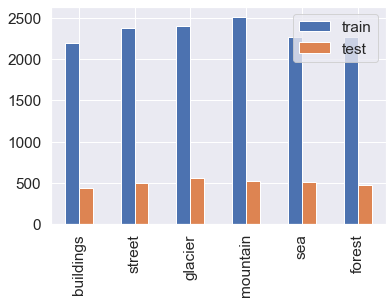

In [54]:
import pandas as pd
class_names = ['buildings', 'street', 'glacier', 'mountain', 'sea', 'forest']

_, train_counts = np.unique(Train_Labels, return_counts=True)
_, test_counts = np.unique(Test_Labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plot.show()

This plot shows the proportion of images for each category.

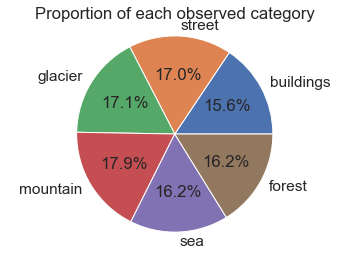

In [55]:
plot.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plot.axis('equal')
plot.title('Proportion of each observed category')
plot.show()

In [56]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plot.figure(figsize=(10,10))
    fig.suptitle("Example Images from data set ", fontsize=16)
    for i in range(25):
        plot.subplot(5,5,i+1)
        plot.xticks([])
        plot.yticks([])
        plot.grid(False)
        plot.imshow(images[i], cmap=plot.cm.binary)
        plot.xlabel(class_names[labels[i]])
    plot.show()

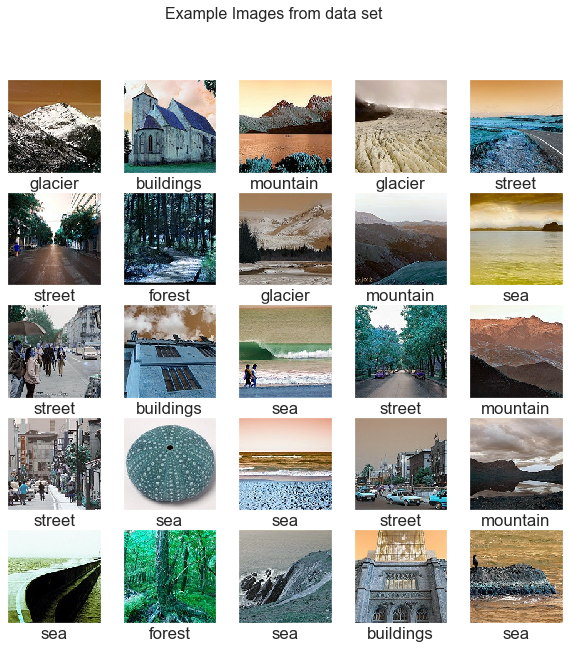

In [57]:
display_examples(class_names, Train_Images, Train_Labels)

### 2. Data Preprocessing

Scaling the train and test images

In [58]:
Train_Images = Train_Images / 255.0 
Test_Images = Test_Images / 255.0

### 3. Build a Deep Learning model using CNN with Keras

Lets start with a simple CNN model first


1. Training data with 2 convolutional layers with 32 neurons (filters) in each layer of size 3 by 3 each.
2. Size of input matrix is 150 by 150 by 3.
3. Max Pooling is applied in each convolution layer with dimension 2 by 2.
4. Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
5. Activation function used is 'Relu'.
6. Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we compile our model with parameters as:

Optimizer: `adam` = RMSProp + Momentum.
Momentum = takes into account past gradient to have a better update.
RMSProp = exponentially weighted average of the squares of past gradients.

Loss: 'y' labels have not been categorized as we are using `sparse_categorical_crossentropy` as our loss.
`sparse_categorical_crossentropy` is a loss function used for labels that are mutually exclusive integers that have not been encoded.


In [60]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               5308544   
_________________________________________________________________
dense_9 (Dense)              (None, 6)                

### Interpreting the summary table:

- for each convolutional layer: 
>$ param = \text{Number of filters} \times ( \text{filter size} \times \text{number of channels in previous layer} + 1) $

- Each filter 3rd dimension is equal to the number of channels of the object filter is convoluted on.

> For example if we have a (28, 28, 3) object, each filter would be (3, 3, 3)

> For example if we have a (32, 32, 64) object, each filter would be (3, 3, 64)

As we can see, the trainable parameters are 5,319,462. So, it is computationally time consuming.

#### Training the model

In [62]:
history = model.fit(Train_Images, Train_Labels, batch_size=64, epochs=20, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/20
11227/11227 [==============================] - 93s 8ms/sample - loss: 1.0628 - acc: 0.6013 - val_loss: 0.8111 - val_acc: 0.7079
Epoch 2/20
11227/11227 [==============================] - 66s 6ms/sample - loss: 0.6597 - acc: 0.7624 - val_loss: 0.6928 - val_acc: 0.7424
Epoch 3/20
11227/11227 [==============================] - 66s 6ms/sample - loss: 0.4665 - acc: 0.8355 - val_loss: 0.6985 - val_acc: 0.7535
Epoch 4/20
11227/11227 [==============================] - 66s 6ms/sample - loss: 0.2928 - acc: 0.9030 - val_loss: 0.7388 - val_acc: 0.7542
Epoch 5/20
11227/11227 [==============================] - 66s 6ms/sample - loss: 0.1669 - acc: 0.9467 - val_loss: 0.8273 - val_acc: 0.7659
Epoch 6/20
11227/11227 [==============================] - 84s 7ms/sample - loss: 0.0910 - acc: 0.9746 - val_loss: 0.8430 - val_acc: 0.7691
Epoch 7/20
11227/11227 [==============================] - 1083s 96ms/sample - loss: 0.0528 - acc: 0.9873 - val_loss: 

#### Saving the model

In [63]:
model.save('intel_image_model1_binny.h5')

In [64]:
score = model.evaluate(Test_Images, Test_Labels, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 1.504
Test Accuracy: 0.762


### The accuracy score on the Test data is 75% only.

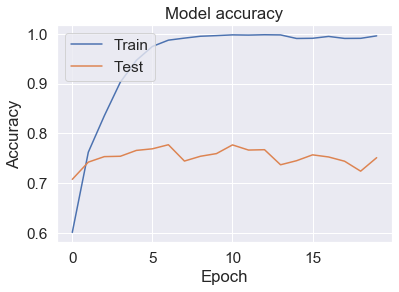

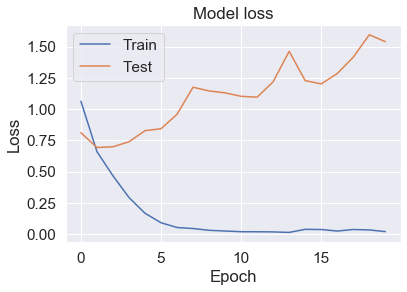

In [65]:
plot.plot(history.history['acc'])
plot.plot(history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

The accuracy of Training set increases with the increase in number of Epochs but for the testing set the accuracy decreases as the epochs increase.

The loss on Training set decreases with the increase in number of Epochs but for the testing set the loss increases as the epochs increases because of overfitting.

#### Error Analysis

We can try to understand on which kind of images the classifier has trouble.

In [66]:
predictions = model.predict(Test_Images)
pred_labels = np.argmax(predictions, axis = 1)

In [67]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    Flag = (test_labels == pred_labels)
    mislabeled_indices = np.where(Flag == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

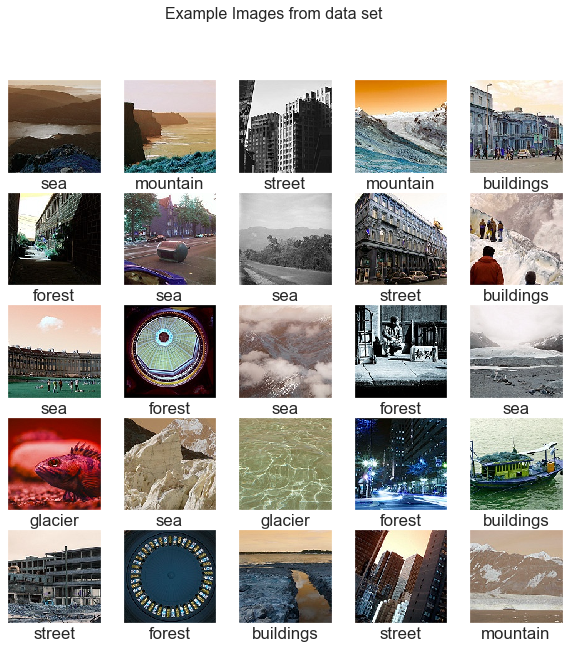

In [68]:
print_mislabeled_images(class_names, Test_Images, Test_Labels, pred_labels)

Confusion matrix

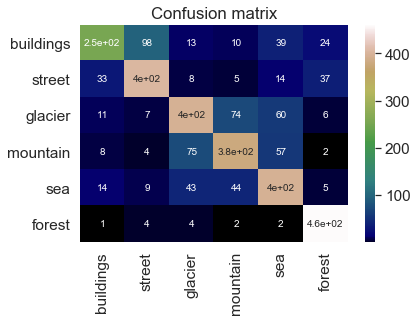

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sn 
sn.set(font_scale=1.4)
CM = confusion_matrix(Test_Labels, pred_labels)
ax = plot.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, cmap='gist_earth')
ax.set_title('Confusion matrix')
plot.show()

Conclusion: As we can see from the heatmap the mountain and glacier, sea and mountains, building and street are highly correlated. So, it is likely that the model misclassifies these images.

Lets try to increase our score by adding more layers to the model and also tuning some hyperparameters.

1. Training data with 6 convolutional layer with increasing neurons (filters) in each layer.
2. The size of the Filter matrix is 3 by 3.
3. Size of input matrix is 150 by 150 by 3.
4. Max Pooling is applied in each convolution layer with dimension 5 by 5. This wil lower the number of trainable parameters by reducing the dimension of the image.
5. Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
6. 4 Dense layers with activation function 'Relu'.
7. Dropout will reduce the parameters by half.
8. Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [70]:
model2 = Models.Sequential()
model2.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model2.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(Layers.MaxPool2D(5,5))
model2.add(Layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model2.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model2.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model2.add(Layers.MaxPool2D(5,5))
model2.add(Layers.Flatten())
model2.add(Layers.Dense(180,activation='relu'))
model2.add(Layers.Dense(100,activation='relu'))
model2.add(Layers.Dense(50,activation='relu'))
model2.add(Layers.Dropout(rate=0.5))
model2.add(Layers.Dense(6,activation='softmax'))


In [71]:
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [72]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 27, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 100)       57700     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 23, 100)       90100     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 21, 21, 50)       

Though we have more layers in this model, the trainable parameters have reduced from the previous model due to larger MaxPooling filter size and Dropout.

#### Training the model

In [73]:
history2 = model2.fit(Train_Images, Train_Labels, batch_size = 64, epochs=20, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/20
11227/11227 [==============================] - 859s 77ms/sample - loss: 1.3499 - acc: 0.4334 - val_loss: 1.0002 - val_acc: 0.5793
Epoch 2/20
11227/11227 [==============================] - 616s 55ms/sample - loss: 1.0327 - acc: 0.5885 - val_loss: 0.8294 - val_acc: 0.6662
Epoch 3/20
11227/11227 [==============================] - 592s 53ms/sample - loss: 0.8916 - acc: 0.6564 - val_loss: 0.7023 - val_acc: 0.7367
Epoch 4/20
11227/11227 [==============================] - 565s 50ms/sample - loss: 0.8054 - acc: 0.7090 - val_loss: 0.6957 - val_acc: 0.7595
Epoch 5/20
11227/11227 [==============================] - 608s 54ms/sample - loss: 0.7234 - acc: 0.7396 - val_loss: 0.6350 - val_acc: 0.7838
Epoch 6/20
11227/11227 [==============================] - 688s 61ms/sample - loss: 0.6473 - acc: 0.7748 - val_loss: 0.5683 - val_acc: 0.8137
Epoch 7/20
11227/11227 [==============================] - 702s 62ms/sample - loss: 0.5631 - acc: 0.8108 -

In [74]:
model2.save('intel_image_model2_binny.h5')

In [75]:
score2 = model2.evaluate(Test_Images, Test_Labels, verbose=0)
print("Test loss: {:.3f}".format(score2[0]))
print("Test Accuracy: {:.3f}".format(score2[1]))

Test loss: 0.506
Test Accuracy: 0.848


### The test accuracy has improved from 75% to 84%

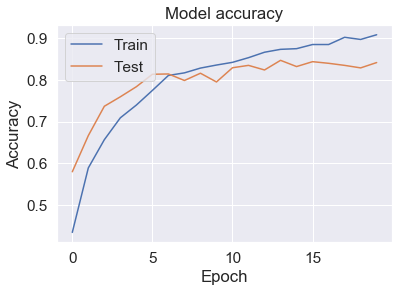

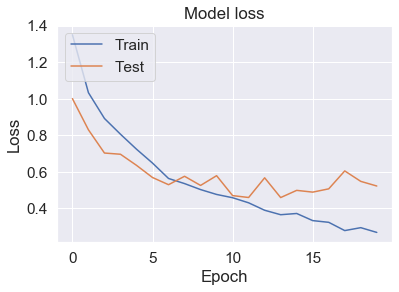

In [76]:
plot.plot(history2.history['acc'])
plot.plot(history2.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(history2.history['loss'])
plot.plot(history2.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

As we can see from the above plots this model is certainly better than the previous model.

# VGG 

- VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”
- Winner of 2014 Imagenet Competition
- It is trained on ImageNet dataset which contains 14k images with 1000 of classes.
- Accuracy on ImageNet dataset is 92.7%.
- It has 13 convolutional layers, 3 Dense layers and 5 Max Pooling layers.
- Architecture focuses more convolutional layer consistency (3x3 filter across the model) rather than having large number of hyper parameters
- Each layer contains a bunch of convolutional layers within itself.
- The key here is with each layer the depth of filters is increased so the network becomes wider.
- It has about 138 million (approx) parameters to train.

In [77]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.ibb.co/4jRVNWv/Whats-App-Image-2020-06-03-at-12-38-58-PM.jpg")

### Training VGG16

1. Input matrix of fixed size 224 by 224 RGB image.
2. Stack of convolutional layers with receptive field of 3 by 3. 
3. The convolution stride is fixed to 1 pixel (step length).
4. The spatial padding of convoluted layer input is 1-pixel. 
5. Spatial pooling is carried out by five max-pooling layers, of 2 by 2 pixel window, with stride 2.
6. Three Dense layers: the first two have 4096 channels each, the third performs 1000-way classification and thus contains 1000 channels and is the soft-max layer. 
7. All hidden layers are equipped with the activation function `ReLU`. 

#### Interesting fact:
As we move from one layer to another and go deeper into the CNN, the image size decreases but the number of filters double as it needs to learn more features.

In [78]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories. The images were collected from the web and labeled by human. In all, there are roughly 1.2 million training images, 50,000 validation images, and 150,000 testing images. ImageNet consists of variable-resolution images. Therefore, the images have been rescaled and cropped out the central 256by256 patch from the resulting image.

Since we have image size of 150 by 150 we directly used VGG16 trained features on Imagnet to determine features for train and test set. 

In [79]:
train_features = model.predict(Train_Images)
test_features = model.predict(Test_Images)

In [80]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

#### To visualize our data we did Principal component analysis

In [81]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

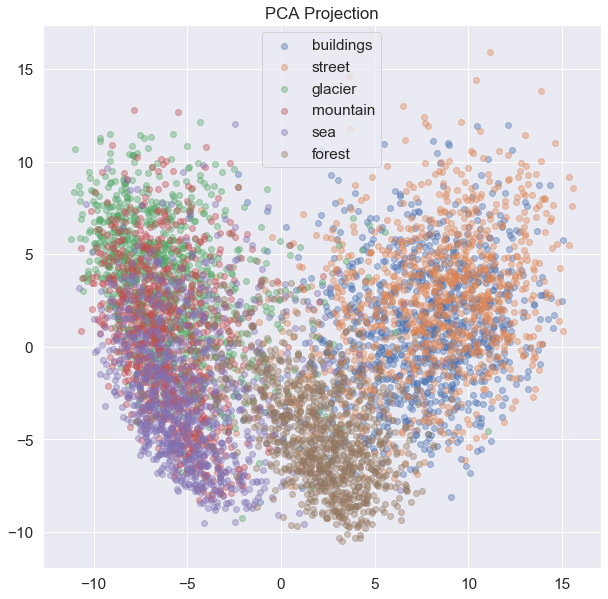

In [82]:
### Figures

plot.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plot.scatter(C1[Train_Labels == i][:1000], C2[Train_Labels == i][:1000], label = class_name, alpha=0.4)
plot.legend()
plot.title("PCA Projection")
plot.show()

We can identify clusters thanks to this PCA. The clusters correspond more or less to the labels.

We see that glacier and mountain points are very close to each other, as VGG sees them as very similar.

We see that there is no distinction between building and street.

#### Training on top of VGG

Let's train a simple one-layer Neural Network on the features extracted from VGG.

In [83]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(train_features, Train_Labels, batch_size=128, epochs=10, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 1s 108us/sample - loss: 0.5653 - acc: 0.8006 - val_loss: 0.3711 - val_acc: 0.8639
Epoch 2/10
11227/11227 [==============================] - 1s 54us/sample - loss: 0.2920 - acc: 0.8986 - val_loss: 0.3308 - val_acc: 0.8807
Epoch 3/10
11227/11227 [==============================] - 1s 54us/sample - loss: 0.2338 - acc: 0.9178 - val_loss: 0.3431 - val_acc: 0.8774
Epoch 4/10
11227/11227 [==============================] - 1s 55us/sample - loss: 0.2011 - acc: 0.9303 - val_loss: 0.3147 - val_acc: 0.8928
Epoch 5/10
11227/11227 [==============================] - 1s 55us/sample - loss: 0.1766 - acc: 0.9394 - val_loss: 0.3278 - val_acc: 0.8874
Epoch 6/10
11227/11227 [==============================] - 1s 57us/sample - loss: 0.1503 - acc: 0.9491 - val_loss: 0.3231 - val_acc: 0.8913
Epoch 7/10
11227/11227 [==============================] - 1s 63us/sample - loss: 0.1239 - acc: 0.9604 - val_loss: 0.

In [84]:
model3.save('intel_image_model3_binny.h5')

In [85]:
score = model3.evaluate(test_features, Test_Labels, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.344
Test Accuracy: 0.883


#### Using the pretrained model from the library our accuracy has gone up to 88%

#### Lets try our own images with model2

In [86]:
from tensorflow.keras.models import load_model

cnn_saved = load_model('intel_image_model2_binny.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [87]:
import matplotlib.image as mpimg

def predict_class(address):
    labels = {0:'buildings', 1:'street', 2:'glacier', 3:'mountain', 4:'sea', 5:'forest'}
    img = mpimg.imread(address, 3)
    plot.imshow(img) 
    plot.show()
    img = cv2.resize(img, (150, 150))
    img = np.reshape(img, [1, 150, 150, 3])
    pred_class = np.argmax(cnn_saved.predict(img))

    for key,values in labels.items():
        if pred_class == key:
            print('predicted image is:', values)

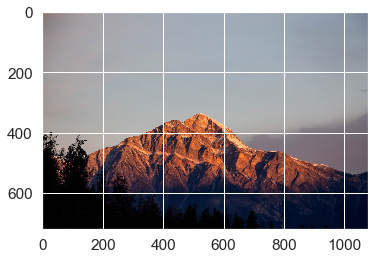

predicted image is: mountain


In [89]:
add  = r'/Users/prajakta.pingale/Downloads/mountain.jpeg'
predict_class(add)

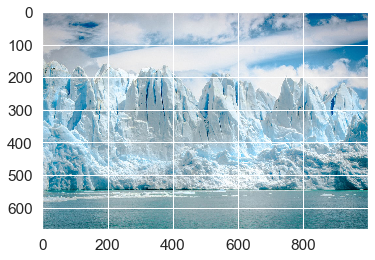

predicted image is: glacier


In [91]:
add  = r"/Users/prajakta.pingale/Downloads/glacier.jpeg"
predict_class(add)

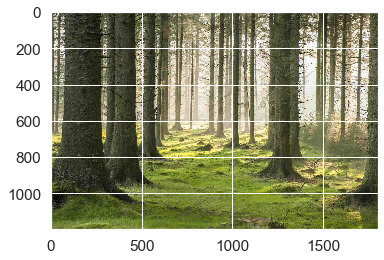

predicted image is: forest


In [92]:
add  = r"/Users/prajakta.pingale/Downloads/forest.jpg"
predict_class(add)

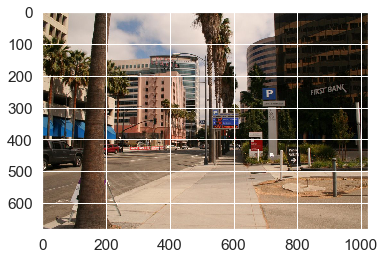

predicted image is: street


In [90]:
add  = r"/Users/prajakta.pingale/Downloads/street.jpg"
predict_class(add)

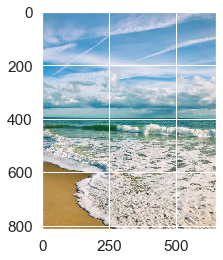

predicted image is: sea


In [93]:
add = r"/Users/prajakta.pingale/Downloads/sea.jpeg"
predict_class(add) 

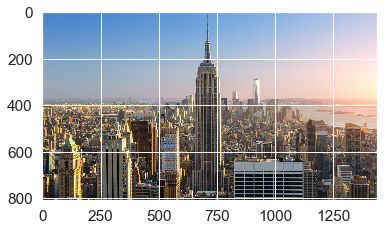

predicted image is: buildings


In [94]:
add = r"/Users/prajakta.pingale/Downloads/building.jpg"
predict_class(add) 